# Demonstration of the TuringOnline package

In this notebook we will provide a use case of the TuringOnline package in order to illustrate its benefits and to provide evidence for the correct working.

The package aims to provide online updates of inferred parameter sets, given parameter samples from e.g. a MCMC algorithm and new, i.e. previously unseen data.

The notebook is structured as follows:

## Table of contents
1. [Used packages](#import)
1. [Model](#model)    
1. [Data generation](#data)
    1. [Independent variables](#data_indep)
    1. [Dependent variables](#data_dep)
    1. [Suitability of generated data](#data_suit)
1. [Benchmark](#bench)
    1. [Speed and memory consumption](#bench_speed)
    1. [Accuracy](#bench_acc)
1. [Repeated updates](#loop)
1. [Summary](#sum)

## Used packages <a name="import"></a>

In [1]:
import PyPlot as plt
import Seaborn as sns
import Pandas as pd

In [2]:
import Random as rnd
import Distributions as dist

In [3]:
import Turing as tur

In [4]:
import AdvancedPS as aps

In [5]:
import DynamicPPL as ppl

In [6]:
rng = rnd.seed!(1)

MersenneTwister(1)

In [7]:
include("../src/TuringOnline.jl")
using Revise
import .online as online

In [115]:
include("./scoring.jl")
import .scoring as scoring

In [8]:
using StatsFuns: logistic

In [9]:
using BenchmarkTools

In [10]:
using Suppressor

In [11]:
import LinearAlgebra

In [12]:
using Distances

In [66]:
import Statistics as stats

## Model <a name="model"></a>

In [13]:
eps=1e-3

0.001

In [14]:
sqexp_cov_fn(D, phi) = exp.(-(D/phi)^2) + LinearAlgebra.I * eps

sqexp_cov_fn (generic function with 1 method)

In [15]:
tur.@model function GP(X,y,cov_fn, m=0, s=1)
    # Dimensions of predictors.
    N = size(X,1)
   
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), X)
    
    # Priors.
    mu ~ dist.Normal(m, s)
    sig2 ~ dist.LogNormal(0, 1)
    phi ~ dist.InverseGamma(3,0.5)
    
    # Realized covariance function
    K = cov_fn(D, phi)
    
    # cov matrix
    cov = LinearAlgebra.Symmetric(K + sig2 * LinearAlgebra.I(N))
    
    # check positive definiteness prior to MvNormal as it can crash
    if ! LinearAlgebra.isposdef(cov)
        cov = LinearAlgebra.Symmetric(sig2 * LinearAlgebra.I(N))
    end
   
    # Sampling Distribution.
    # The latent variables have been marginalized out here,
    # so there's only one level.
    y ~ dist.MvNormal(mu * ones(N),cov)

    return (y=y,mu=mu,sig2=sig2,phi=phi)
end

GP (generic function with 4 methods)

## Generate test data <a name="data"></a>
We generate data synthetically by drawing from the model to rule out modelling errors as a cause for bad inference performance.

### Independent variables <a name="data_indep"></a>

In [16]:
numTimeSteps = 50;

In [17]:
time = range(0; stop=5, length=numTimeSteps)

0.0:0.10204081632653061:5.0

### Prior samples for parameters and dependent variable <a name="data_dep"></a>

In [18]:
missing_y =  fill(missing,numTimeSteps);

In [19]:
m_missing_full = GP(time,missing_y[1],sqexp_cov_fn)

DynamicPPL.Model{typeof(GP), (:X, :y, :cov_fn, :m, :s), (:m, :s), (:y,), Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Missing, typeof(sqexp_cov_fn), Int64, Int64}, Tuple{Int64, Int64}, DynamicPPL.DefaultContext}(:GP, GP, (X = 0.0:0.10204081632653061:5.0, y = missing, cov_fn = sqexp_cov_fn, m = 0, s = 1), (m = 0, s = 1), DynamicPPL.DefaultContext())

In [20]:
prior_chain = tur.sample(m_missing_full, tur.Prior(), 2)

Chains MCMC chain (2×54×1 Array{Float64, 3}):

Iterations        = 1:1:2
Number of chains  = 1
Samples per chain = 2
Wall duration     = 5.68 seconds
Compute duration  = 5.68 seconds
parameters        = mu, sig2, phi, y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], y[15], y[16], y[17], y[18], y[19], y[20], y[21], y[22], y[23], y[24], y[25], y[26], y[27], y[28], y[29], y[30], y[31], y[32], y[33], y[34], y[35], y[36], y[37], y[38], y[39], y[40], y[41], y[42], y[43], y[44], y[45], y[46], y[47], y[48], y[49], y[50]
internals         = lp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Missing   Missing      ⋯

          mu    0.1335    0.2316     0.1638    0.1638   missing   missing      ⋯
        sig2    1.0814    0.5437     0.3844    0.3844   missing   missing      ⋯
         phi    0.9017    0.8451     0.5976    0.5976   missing   missing 

In [21]:
generated = tur.generated_quantities(m_missing_full, prior_chain);

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


In [22]:
y = tur.generated_quantities(m_missing_full, prior_chain)[1][:y]

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp"]
└ @ DynamicPPL /home/konstantin/.julia/packages/DynamicPPL/RcfQU/src/varinfo.jl:1311


50-element Vector{Float64}:
 -0.718867541866441
  0.6740786728045314
  3.076896484038134
 -2.4484075913734156
  0.9391356753545212
  0.8197877901021824
  1.0042241202706048
  1.4639178245286935
  0.8529352346829828
 -0.3353203520396399
  0.7919011019851532
  0.23618589245973792
 -0.5428042960312074
  ⋮
  0.3826321450720065
  0.711238531882072
  2.398768016504759
  1.8716318617098768
  0.5472180084330726
 -0.9245544556948306
 -0.7322246736374887
  1.665129351997279
 -1.3359371228424373
  1.7994192288746405
  0.22989311988358047
  1.2169946167604337

In [23]:
trueVals = Dict()

Dict{Any, Any}()

In [24]:
@suppress begin

for key in [:mu,:sig2,:phi]
    trueVals[key] = tur.generated_quantities(m_missing_full, prior_chain)[1][key]
end
trueVals
end

Dict{Any, Any} with 3 entries:
  :mu   => 0.297288
  :phi  => 0.304072
  :sig2 => 1.46579

### Show the data

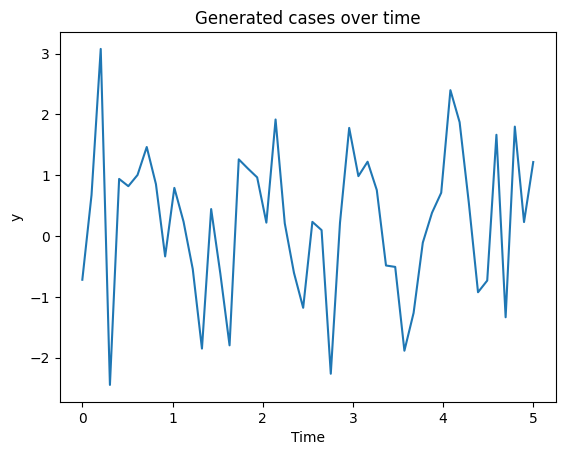

In [25]:
plt.title("Generated cases over time")
plt.plot(time,y);
plt.ylabel("y");
plt.xlabel("Time");

### Show suitablity by inference through NUTS with full data <a name="data_suit"></a>
We consider the NUTS algorithm as a reference standard and show that the data contains enough information for a meaningful inference.

In [26]:
m_full = GP(time,y,sqexp_cov_fn);

In [27]:
NUTS = tur.NUTS();

In [28]:
num_chains = 2
num_samples = 1000;

In [29]:
chain_NUTS_full =  tur.sample(m_full, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [30]:
summaryNUTS = tur.summarize(chain_NUTS_full).nt

(parameters = [:mu, :sig2, :phi], mean = [0.23840841358384604, 1.5395578057370172, 0.24983094699723477], std = [0.1670500886183906, 0.313960411139276, 0.2459514322457179], naive_se = [0.0037353535379808524, 0.0070203682155120335, 0.005499641216648592], mcse = [0.0033815885808176353, 0.006121076750443335, 0.009894657293850596], ess = [2102.151006098725, 2255.042327132871, 709.8386665567729], rhat = [0.9991453673656681, 0.9996504319656441, 1.002666782182319], ess_per_sec = [88.15528835438752, 94.56690124687037, 29.7676200015421])

In [116]:
scoring.getScore(chain_NUTS_full,[:mu,:phi,:sig2],trueVals)

8.489021953776204

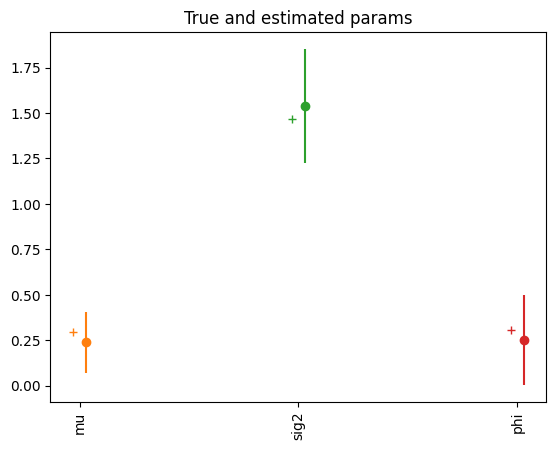

In [31]:
jitter = 0.03
plt.title("True and estimated params")
for (i,p) in enumerate(summaryNUTS.parameters)
  plt.plot(i-jitter,trueVals[p],"+",label="True",color="C$i");
  plt.errorbar(x=i+jitter,y=summaryNUTS.mean[i],yerr=summaryNUTS.std[i],fmt="o",color="C$i",label="Est")
end

# ticks
plt.xticks(1:length(summaryNUTS.parameters), summaryNUTS.parameters, rotation="vertical")

#plt.legend();
#plt.ylabel("theta")
#plt.xlabel("Time");

As the estimated parameters match the true values by eye, we conclude that this data and model can be considered as a suitable testing ground.

## Benchmark of updating <a name="bench"></a>
We consider the situation where data and inferred parameters up to a point t in time are available and new data arrives at time t+1.

In [32]:
someTime = length(time)-10

40

In [33]:
y_t =  y[1:someTime]

40-element Vector{Float64}:
 -0.718867541866441
  0.6740786728045314
  3.076896484038134
 -2.4484075913734156
  0.9391356753545212
  0.8197877901021824
  1.0042241202706048
  1.4639178245286935
  0.8529352346829828
 -0.3353203520396399
  0.7919011019851532
  0.23618589245973792
 -0.5428042960312074
  ⋮
  0.21642447209779958
  1.7778262493580634
  0.984830791668541
  1.2219707302181844
  0.7558136467835658
 -0.48460238464467603
 -0.507673085312818
 -1.8863789076640074
 -1.263893090415111
 -0.10876164588755105
  0.3826321450720065
  0.711238531882072

In [34]:
y_t_inc = y[1:someTime+1]

41-element Vector{Float64}:
 -0.718867541866441
  0.6740786728045314
  3.076896484038134
 -2.4484075913734156
  0.9391356753545212
  0.8197877901021824
  1.0042241202706048
  1.4639178245286935
  0.8529352346829828
 -0.3353203520396399
  0.7919011019851532
  0.23618589245973792
 -0.5428042960312074
  ⋮
  1.7778262493580634
  0.984830791668541
  1.2219707302181844
  0.7558136467835658
 -0.48460238464467603
 -0.507673085312818
 -1.8863789076640074
 -1.263893090415111
 -0.10876164588755105
  0.3826321450720065
  0.711238531882072
  2.398768016504759

In [35]:
model_t = GP(time[1:someTime],y_t,sqexp_cov_fn)

DynamicPPL.Model{typeof(GP), (:X, :y, :cov_fn, :m, :s), (:m, :s), (), Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Vector{Float64}, typeof(sqexp_cov_fn), Int64, Int64}, Tuple{Int64, Int64}, DynamicPPL.DefaultContext}(:GP, GP, (X = 0.0:0.10204081632653061:3.979591836734694, y = [-0.718867541866441, 0.6740786728045314, 3.076896484038134, -2.4484075913734156, 0.9391356753545212, 0.8197877901021824, 1.0042241202706048, 1.4639178245286935, 0.8529352346829828, -0.3353203520396399  …  0.984830791668541, 1.2219707302181844, 0.7558136467835658, -0.48460238464467603, -0.507673085312818, -1.8863789076640074, -1.263893090415111, -0.10876164588755105, 0.3826321450720065, 0.711238531882072], cov_fn = sqexp_cov_fn, m = 0, s = 1), (m = 0, s = 1), DynamicPPL.DefaultContext())

In [36]:
model_t_inc = GP(time[1:someTime+1],y_t_inc,sqexp_cov_fn)

DynamicPPL.Model{typeof(GP), (:X, :y, :cov_fn, :m, :s), (:m, :s), (), Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Vector{Float64}, typeof(sqexp_cov_fn), Int64, Int64}, Tuple{Int64, Int64}, DynamicPPL.DefaultContext}(:GP, GP, (X = 0.0:0.10204081632653061:4.081632653061225, y = [-0.718867541866441, 0.6740786728045314, 3.076896484038134, -2.4484075913734156, 0.9391356753545212, 0.8197877901021824, 1.0042241202706048, 1.4639178245286935, 0.8529352346829828, -0.3353203520396399  …  1.2219707302181844, 0.7558136467835658, -0.48460238464467603, -0.507673085312818, -1.8863789076640074, -1.263893090415111, -0.10876164588755105, 0.3826321450720065, 0.711238531882072, 2.398768016504759], cov_fn = sqexp_cov_fn, m = 0, s = 1), (m = 0, s = 1), DynamicPPL.DefaultContext())

#### Get a chain from nuts
We assume here that the parameter set up to time t is also available, we use NUTS as a reference for that:

In [37]:
chain_t = tur.sample(model_t, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Chains MCMC chain (1000×15×2 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 2
Samples per chain = 1000
Wall duration     = 7.66 seconds
Compute duration  = 7.65 seconds
parameters        = mu, sig2, phi
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          mu    0.1357    0.1848     0.0041    0.0038   1871.1173    0.9996    ⋯
        sig2    1.4877    0.3360     0.0075    0.0080   2244.2979    1.0006    ⋯
         phi    0.2405    0.1833     0.0041    0.0046   1472.4892    1.0038    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.

### Speed and memory consumption <a name="bench_speed"></a>

In [38]:
@benchmark online.update(chain_t,model_t_inc,tur.SMC(),rng) seconds = 60

BenchmarkTools.Trial: 45 samples with 1 evaluation.
 Range (min … max):  921.964 ms …    2.632 s  ┊ GC (min … max): 10.21% … 8.44%
 Time  (median):        1.216 s               ┊ GC (median):    11.86%
 Time  (mean ± σ):      1.355 s ± 381.605 ms  ┊ GC (mean ± σ):  14.37% ± 7.08%

    ▄█▄▁▄ ▄▁▁ ▁         ▁ ▁▁    ▁                                
  ▆▆█████▁███▁█▆▆▆▁▁▁▆▁▆█▁██▁▆▁▁█▁▁▆▆▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▆ ▁
  922 ms           Histogram: frequency by time          2.63 s <

 Memory estimate: 539.20 MiB, allocs estimate: 944517.

In [39]:
@benchmark tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true) seconds = 60

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2328125
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/kons

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


BenchmarkTools.Trial: 8 samples with 1 evaluation.
 Range (min … max):  7.136 s …    9.493 s  ┊ GC (min … max): 3.86% … 3.47%
 Time  (median):     7.537 s               ┊ GC (median):    3.72%
 Time  (mean ± σ):   7.947 s ± 833.245 ms  ┊ GC (mean ± σ):  3.60% ± 0.18%

  █  █   ██ █                     █     █                  █  
  █▁▁█▁▁▁██▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  7.14 s         Histogram: frequency by time         9.49 s <

 Memory estimate: 6.98 GiB, allocs estimate: 1789959.

The two results above indicate that the online updates is faster and requires less memory.

### Accuracy <a name="bench_acc"></a>
We compare the estimated values from the online update and from NUTS to the true values.

In [40]:
newChain = online.update(chain_t,model_t_inc,tur.SMC(),rng);

In [41]:
chain_t_inc = tur.sample(model_t_inc, NUTS, tur.MCMCThreads(), num_samples, num_chains; discard_adapt=true);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


In [117]:
scoring.getScore(chain_t_inc,[:mu,:phi,:sig2],trueVals)

7.438270459014338

In [118]:
scoring.getScore(newChain,[:mu,:phi,:sig2],trueVals)

8.063329487385602

In [42]:
dictChains = Dict("Update" => newChain, "NUTS" => chain_t_inc , "True" => prior_chain);

In [43]:
dictColor = Dict("Update" => "C1", "NUTS" => "C2" , "True" => "k");

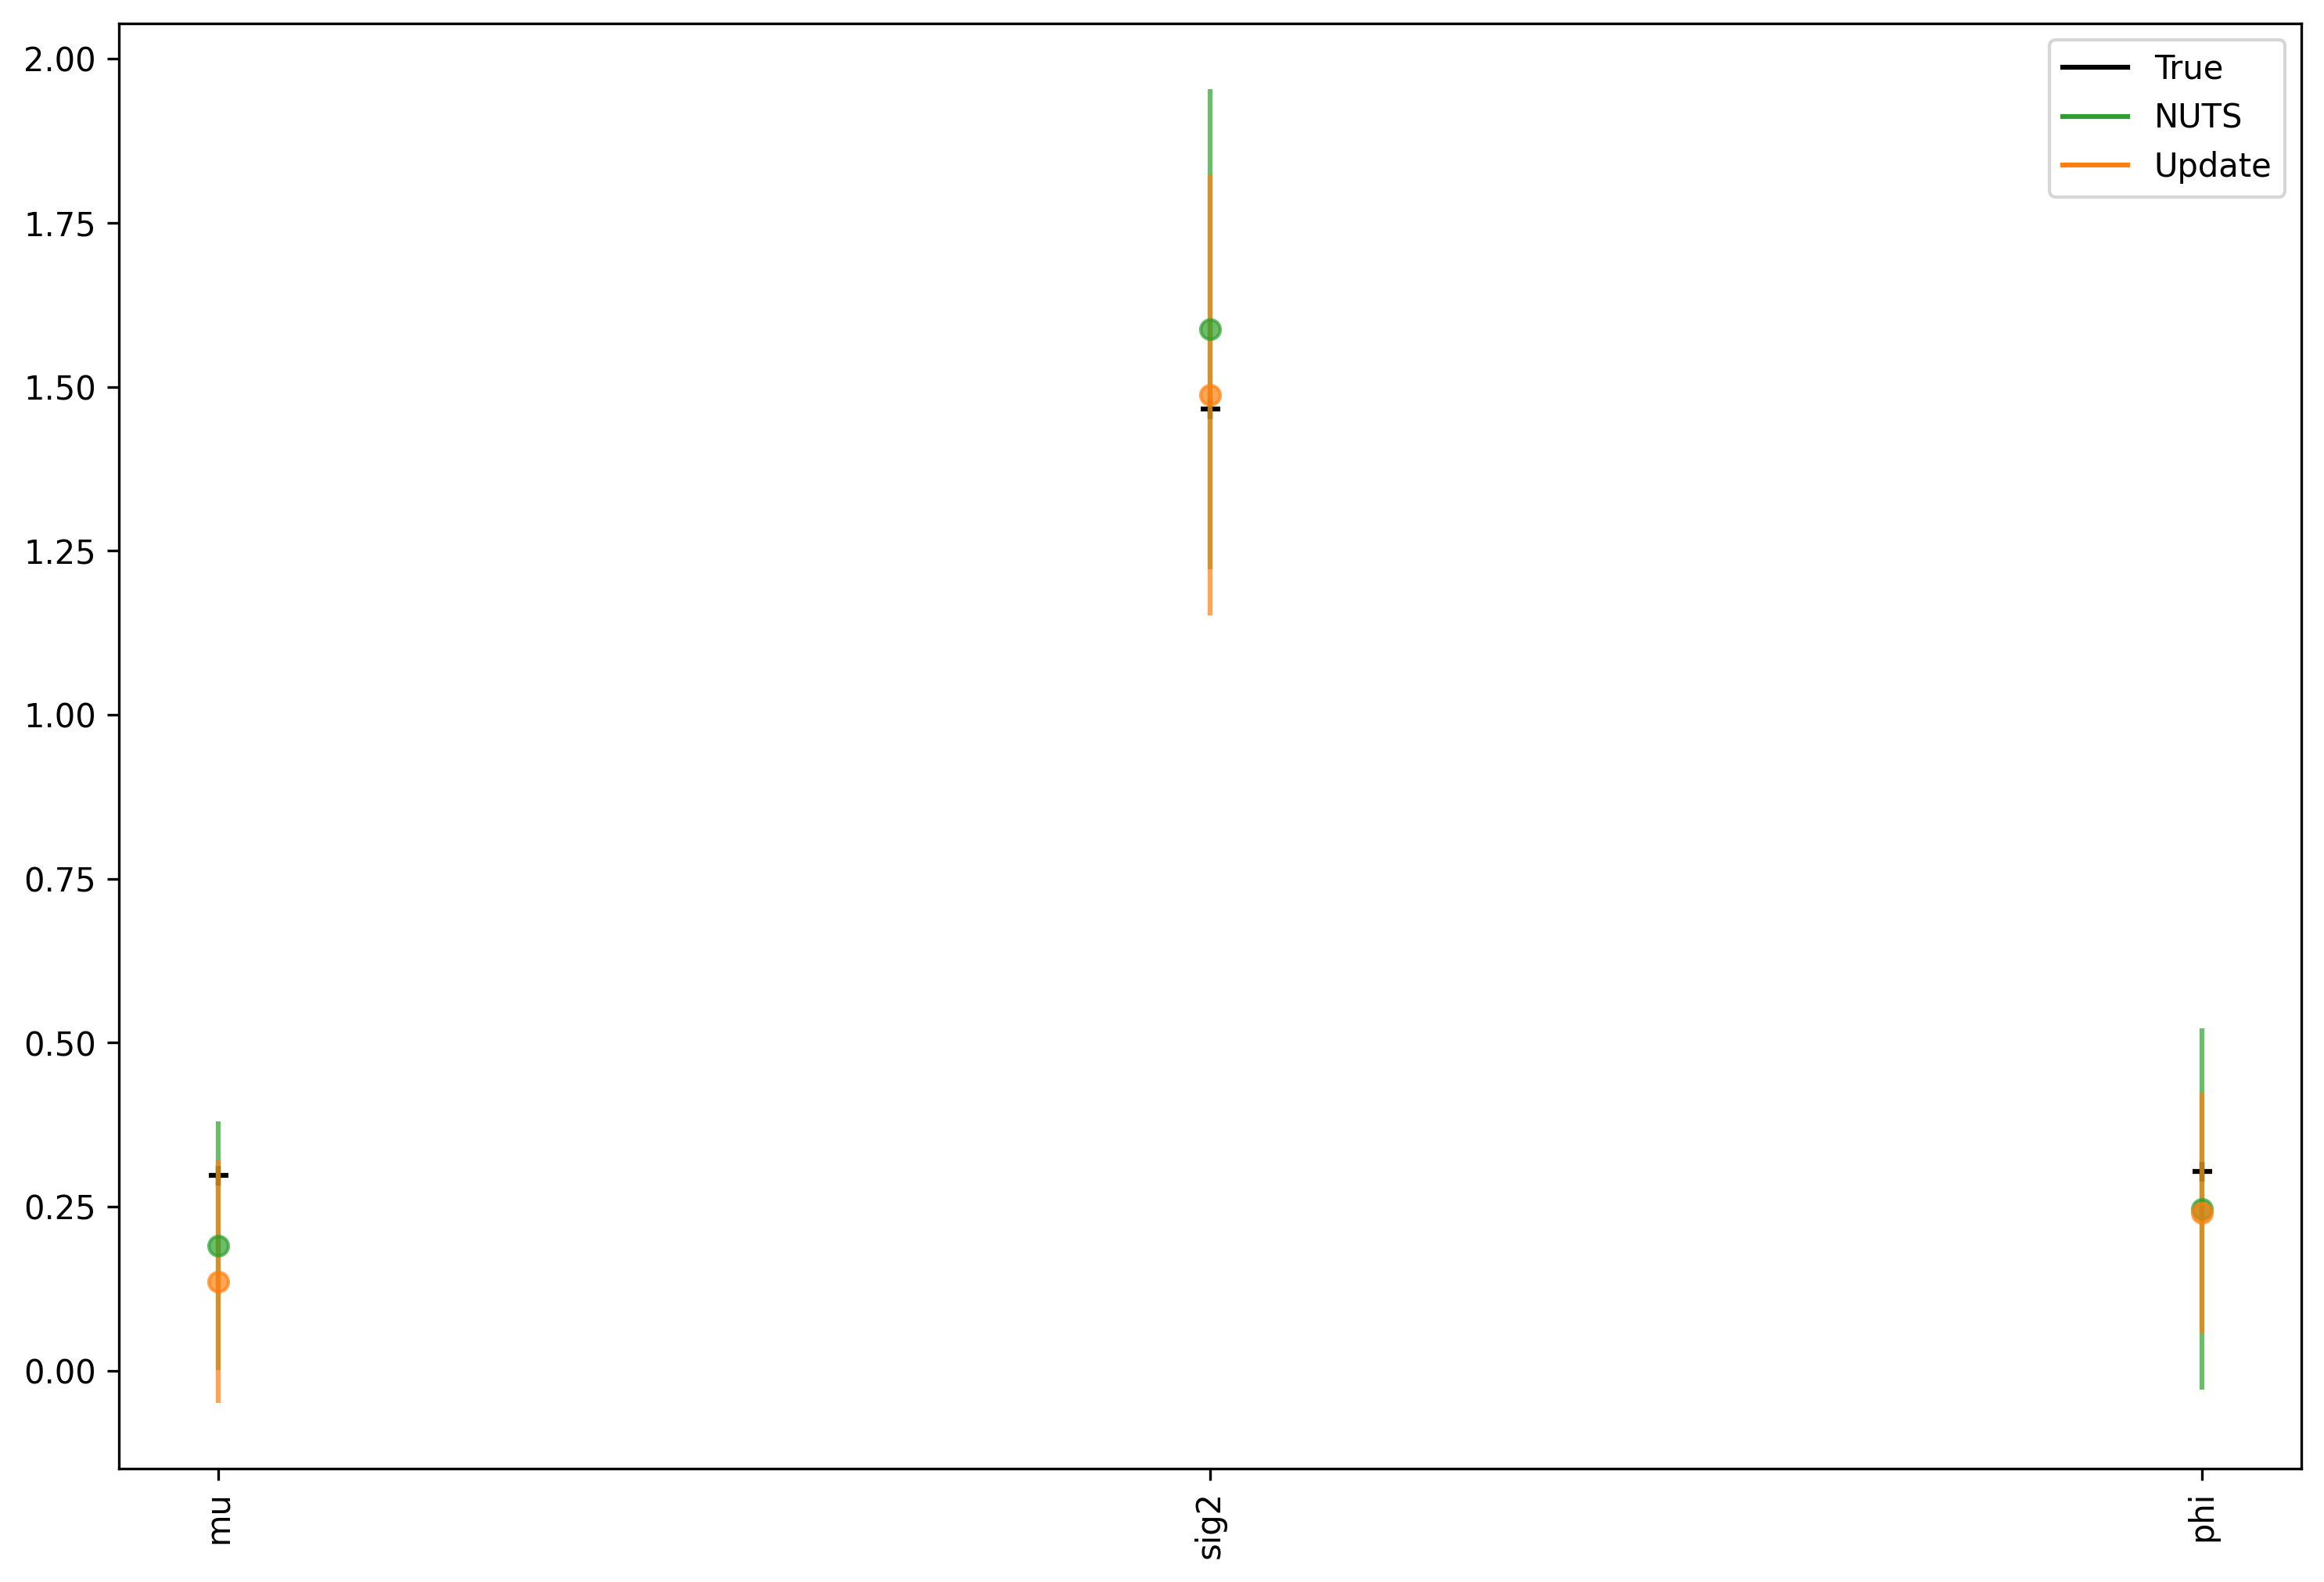

In [44]:
plt.figure(figsize=(12,8),dpi=300)
for (i,sym) in enumerate(chain_t_inc.name_map.parameters)
    for (k,v) in dictChains
        if sym in v.name_map.parameters
            if k != "True"
                # compute statistics
                samples = collect(Iterators.flatten(v[sym].data))
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # plot errorbars
                plt.errorbar(x=i,y=mean,yerr=std,fmt="o",color=dictColor[k],alpha=0.7)
            else 
                # plot true
                plt.scatter([i],v[sym].data[1,:],color="k",marker="+")
            end
        end        
    
    end
end
# add labels
for (ckey,cvalue) in dictColor
    plt.plot([],[],label=ckey,color=cvalue)
end
plt.legend()

# ticks
plt.xticks(1:length(chain_t_inc.name_map.parameters), chain_t_inc.name_map.parameters, rotation="vertical")

plt.show()

The performance of both algorithms is similar as all estimates are within a fraction of the corresponding standard deviations.

## Repeated updates <a name="loop"></a>
We investigate the repeated use of the online update over a time series.

In [45]:
chainDict = Dict()

Dict{Any, Any}()

In [46]:
smc = tur.SMC()

Turing.Inference.SMC{(), AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}}(AdvancedPS.ResampleWithESSThreshold{typeof(AdvancedPS.resample_systematic), Float64}(AdvancedPS.resample_systematic, 0.5))

In [47]:
for (i,t) in enumerate(time)
   
    # set up model
    model_t = GP(time[1:i],y[1:i],sqexp_cov_fn)
    
    if i == 1
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    elseif i ==2
        println("NUTS at $i")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"NUTS")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    else
        println("NUTS at $i.")
        chainDict[(i,"NUTS")] = tur.sample(model_t, NUTS, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
        println("Online at $i")
        chainDict[(i,"Online")] = online.update(chainDict[(i-1,"Online")],model_t,tur.SMC(),rng)
        println("SMC at $i")
        chainDict[(i,"SMC")] = tur.sample(model_t, smc, tur.MCMCThreads(), 100, num_chains; discard_adapt=true)
    end
end

NUTS at 1
SMC at 1


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 3.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 2
Online at 2


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 2
NUTS at 3.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 3
SMC at 3
NUTS at 4.
Online at 4


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 4
NUTS at 5.
Online at 5


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 5
NUTS at 6.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 6
SMC at 6
NUTS at 7.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 7
SMC at 7
NUTS at 8.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 8
SMC at 8
NUTS at 9.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 9
SMC at 9


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 10.
Online at 10


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 10
NUTS at 11.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 11
SMC at 11
NUTS at 12.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


Online at 12


┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


SMC at 12
NUTS at 13.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 13
SMC at 13


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 14.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 14
SMC at 14
NUTS at 15.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.80625
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 15
SMC at 15
NUTS at 16.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 16
SMC at 16
NUTS at 17.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 17
SMC at 17
NUTS at 18.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 18
SMC at 18
NUTS at 19.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 19
SMC at 19
NUTS at 20.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 20
SMC at 20
NUTS at 21.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 1.6
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 21
SMC at 21
NUTS at 22.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 22
SMC at 22
NUTS at 23.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 23
SMC at 23
NUTS at 24.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 24
SMC at 24
NUTS at 25.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 25
SMC at 25
NUTS at 26.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 26
SMC at 26
NUTS at 27.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 27
SMC at 27
NUTS at 28.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 28
SMC at 28
NUTS at 29.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 29
SMC at 29
NUTS at 30.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 30
SMC at 30
NUTS at 31.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 31
SMC at 31


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 32.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 32
SMC at 32
NUTS at 33.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 33
SMC at 33


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 34.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 34
SMC at 34


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 35.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 35
SMC at 35


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 36.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 36
SMC at 36


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 37.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 37
SMC at 37


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 38.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 38
SMC at 38


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 39.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 39
SMC at 39


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 40.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 40
SMC at 40


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 41.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 41
SMC at 41


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 42.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 42
SMC at 42


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 43.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 43
SMC at 43


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 44.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 44
SMC at 44


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 45.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 45
SMC at 45


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 46.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 46
SMC at 46


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 47.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 47
SMC at 47


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 48.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.40625
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 48
SMC at 48


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 49.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 49
SMC at 49


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


NUTS at 50.


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/konstantin/.julia/packages/Turing/uMQmD/src/inference/hmc.jl:188


Online at 50
SMC at 50


┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/konstantin/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


### Analysis

In [48]:
chainDict

Dict{Any, Any} with 149 entries:
  (15, "SMC")    => MCMC chain (100×5×2 Array{Float64, 3})
  (41, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (11, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (36, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (43, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (47, "Online") => MCMC chain (100×5×2 Array{Float64, 3})
  (48, "SMC")    => MCMC chain (100×5×2 Array{Float64, 3})
  (14, "Online") => MCMC chain (100×5×2 Array{Float64, 3})
  (3, "Online")  => MCMC chain (100×5×2 Array{Float64, 3})
  (5, "SMC")     => MCMC chain (100×5×2 Array{Float64, 3})
  (39, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (35, "SMC")    => MCMC chain (100×5×2 Array{Float64, 3})
  (7, "NUTS")    => MCMC chain (100×15×2 Array{Float64, 3})
  (25, "NUTS")   => MCMC chain (100×15×2 Array{Float64, 3})
  (33, "Online") => MCMC chain (100×5×2 Array{Float64, 3})
  (30, "SMC")    => MCMC chain (100×5×2 Array{Float64, 3})
  (40, "Online")

In [49]:
function plotEstimates(chainDict,name,prior_chain)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) && Symbol(name) in chainDict[key].name_map.parameters
                samples = collect(Iterators.flatten(chainDict[key][Symbol(name)].data))                
                mean = dist.mean(samples)
                std = dist.std(samples)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=mean,yerr=std,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end    
    
    # Show true value
    trueVal = prior_chain[Symbol(name)].data[1,1]
    plt.plot(times,trueVal.*ones(length(times)),color="k",label="True")
    plt.legend()
    
    # set labels
    plt.ylabel(name)
    plt.xlabel("Timestep")
    
    return nothing
end    

plotEstimates (generic function with 1 method)

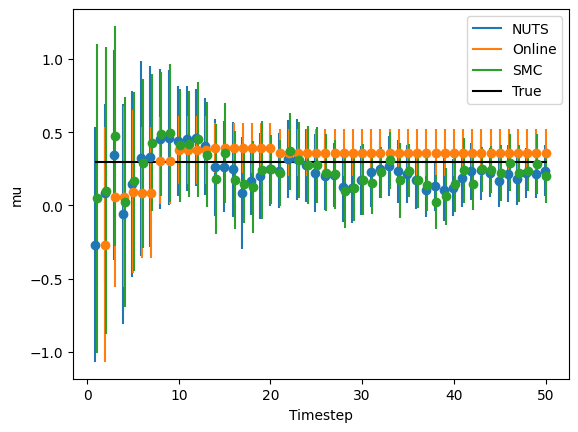

In [50]:
plotEstimates(chainDict,"mu",prior_chain)

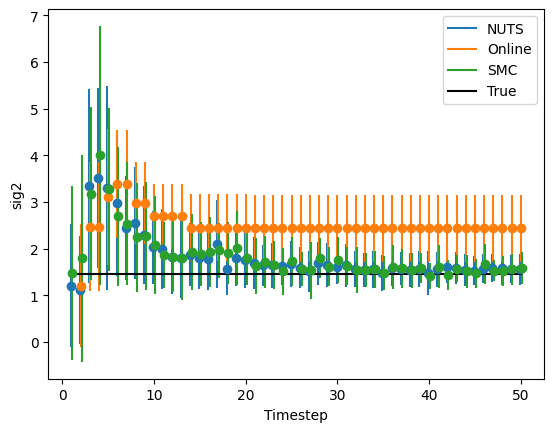

In [51]:
plotEstimates(chainDict,"sig2",prior_chain)

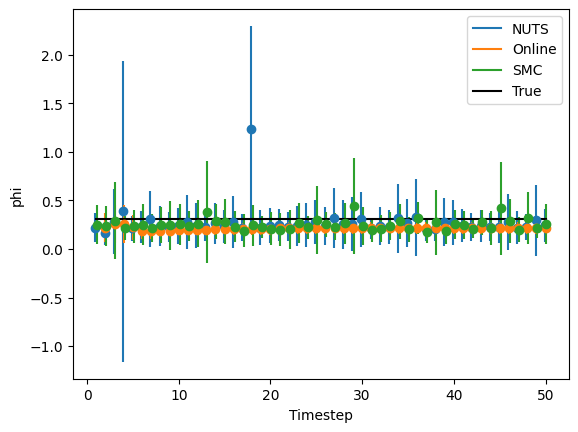

In [52]:
plotEstimates(chainDict,"phi",prior_chain)

In general, the estimates of the online update agree with the ones of NUTS and the true value within one standard deviation. However, over repteated iterations there is a tendency to converge to narrow range of values. This degenaration could be rooted in the nature of the particle based methods.

In [125]:
function plotScores(chainDict,params,trueVals)
    # time indices
    times = sort(unique([t for (t,m) in keys(chainDict)]))
    
    colorDict = Dict("NUTS" => "C0","Online" => "C1","SMC" => "C2")
    jitter = 0.09
    jitterDict = Dict("NUTS" => -jitter,"Online" => 0.0,"SMC" => jitter)
    
    methods = ["NUTS","Online","SMC"]
    
    # extract values
    for method in methods
        for t in times
            key = (t,method)           
            if haskey(chainDict, key) 
                chain = chainDict[key]
                score = scoring.getScore(chain,params,trueVals)
                
                # pseudo x with jitter
                x = t
                x += jitterDict[method]

                # plot errorbars
                plt.errorbar(x=x,y=score,fmt="o",color=colorDict[method])
            end
        end    
    end

    # Add legend
    for method in methods
       plt.plot([],[],color=colorDict[method],label=method) 
    end  
    plt.legend()
    
    # set labels
    plt.ylabel("Score")
    plt.xlabel("Timestep")
    
    return nothing
end

plotScores (generic function with 1 method)

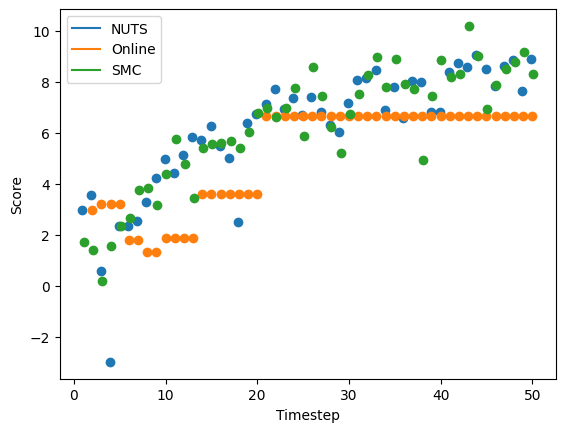

In [126]:
plotScores(chainDict,[:mu,:phi,:sig2],trueVals)

## Summary <a name="sum"></a>
We could show that the online updates provided by the TuringOnline package offer a way to get estimates of similar quality, but in less time and with less memory consumption than rerunning the estimation with a reference algorithm like NUTS.

For repteated usage there is the danger of the updated to converge to a narrow range after several updates, such that there may be a certain limit of steps after which one should refresh the estimates by a complete run of e.g. NUTS.